<a href="https://colab.research.google.com/github/evmpython/linkedin/blob/main/02b_mapa_relampagos_GOES16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **ACUMULADO DE RELÂMPAGOS COM DADOS DO GOES-16**
---

- GOES-16 `5 min`

1. url dos dados: http://ftp.cptec.inpe.br/goes/goes16/goes16_web/glm_acumulado_nc/


---


- Código realizado por: Enrique V. Mattos -- 02/05/2024 - enrique@unifei.edu.br


---



# **1° Passo:** Instalando as bibliotecas

In [1]:
# Instalando matplotlib, proplot e numpy
!pip install -q matplotlib==3.4.3
!pip install -q proplot==0.9.7
!pip install -q numpy==1.24.3

# Instalando salem
!pip install -q salem==0.3.9

# Instalando rasterio, pyproj e geopandas
!pip install -q rasterio pyproj geopandas

# Instalando cartopy
!pip uninstall shapely --yes
!pip install -q shapely cartopy==0.21.1 --no-binary shapely --no-binary cartopy

Found existing installation: shapely 2.0.4
Uninstalling shapely-2.0.4:
  Successfully uninstalled shapely-2.0.4


- Chegando aqui, será necessário fazer a `Reinicialização do Ambiente de Execução`. Para isto, você deverá acessar `Ambiente de execução`, localizado na barra de ferramentas e clicar em `Reiniciar Sessão`. Como indicado na imagem abaixo.

- Em seguida você deverá rodar novamente a célula anterior de instalações, de forma que as bibliotecas sejam instaladas novamente.

- Isso é necessário tanto para poder usar sem problemas o `Proplot` quanto o `CartoPy` na nossa sessão do Colab. Então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

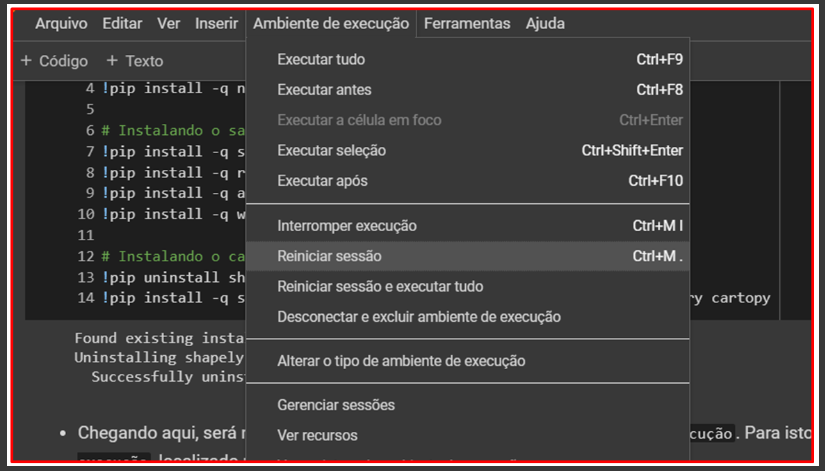

# **2° Passo:** Importando bibliotecas

In [2]:
import xarray as xr
import time
import proplot as pplt
import salem
import matplotlib
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import pandas as pd
import glob

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


# **3° Passo:** Monta drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/PYHTON/00_GITHUB/16_LINKEDIN/dados_glm_5min/'

Mounted at /content/drive


# **4° Passo:** Carrega shapefile

In [4]:
# url dos shapefiles
url = 'https://github.com/evmpython/shapefile/raw/main/'

# leitura do shapefile com a biblioteca SALEM
shp = salem.read_shapefile(f'{url}brasil/BRAZIL.shp')

# Limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

#Define a data inicial e final

In [5]:
# define mês e ano
anoi, mesi, diai = '2024', '04', '26'
anof, mesf, diaf = '2024', '05', '01'
mesi_name, mesf_name = 'abril', 'maio'

# selecina a extensão da imagem [min. lon, min. lat, max. lon, max. lat]
extent = [lonmin, latmin, lonmax, latmax]

#Leitura dos dados

In [6]:
# lista os arquivos
files = sorted(glob.glob(f'{dir}S11635949_*nc'))

# mostra o primeiro e último arquivo
print(files[0], files[-1])

/content/drive/MyDrive/PYHTON/00_GITHUB/16_LINKEDIN/dados_glm_5min/S11635949_202404260000.nc /content/drive/MyDrive/PYHTON/00_GITHUB/16_LINKEDIN/dados_glm_5min/S11635949_202404301240.nc


In [7]:
%%time
# leitura do dado: demora 3 min
glm_5min = xr.open_mfdataset(files,
                             concat_dim='time',
                             combine='nested').sel(lon=slice(lonmin,lonmax), lat=slice(latmin,latmax))

# mostra a matriz dos dados
glm_5min

CPU times: user 1min 8s, sys: 6.9 s, total: 1min 15s
Wall time: 3min 53s


<xarray.Dataset>
Dimensions:         (time: 1288, lat: 525, lon: 525)
Coordinates:
  * time            (time) datetime64[ns] 2024-04-26 ... 2024-04-30T12:40:00....
  * lat             (lat) float32 -34.96 -34.88 -34.8 -34.72 ... 6.8 6.88 6.96
  * lon             (lon) float32 -75.0 -74.92 -74.84 ... -33.24 -33.16 -33.08
Data variables:
    spatial_ref     (time) int32 -2147483647 -2147483647 ... -2147483647
    event           (time, lat, lon) float32 dask.array<chunksize=(1, 525, 525), meta=np.ndarray>
    flash           (time, lat, lon) float32 dask.array<chunksize=(1, 525, 525), meta=np.ndarray>
    group           (time, lat, lon) float32 dask.array<chunksize=(1, 525, 525), meta=np.ndarray>
    event_energy    (time, lat, lon) float32 dask.array<chunksize=(1, 525, 525), meta=np.ndarray>
    flash_energy    (time, lat, lon) float32 dask.array<chunksize=(1, 525, 525), meta=np.ndarray>
    group_energy    (time, lat, lon) float32 dask.array<chunksize=(1, 525, 525), meta=np.ndarray>
    duration_flash  (time, lat, lon) float32 dask.array<chunksize=(1, 525, 525), meta=np.ndarray>
    flash_count     (time) int16 1010 989 1030 1003 995 ... 454 446 465 467 439
    group_count     (time) int16 2067 2067 2123 2086 2101 ... 1117 1097 1135 975
    event_count     (time) int16 4368 4377 4595 4545 ... 2323 2444 2328 1904
Attributes:
    description:  Center for Weather Forecasting and Climate Studies/INPE
    history:      Create in Fri Apr 26 00:09:09 2024
    source:       GLM Lightning Accumulated (5 minutes) - GOES 16 ['OR_GLM-L2...

In [8]:
# soma os dados
flash = glm_5min['flash'].sum(dim='time')

# seleciona área do Brasil
flash = flash.salem.roi(shape=shp)

# mostra mapa simples
#flash.plot()

In [9]:
flash

<xarray.DataArray 'flash' (lat: 525, lon: 525)>
dask.array<where, shape=(525, 525), dtype=float32, chunksize=(525, 525), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -34.96 -34.88 -34.8 -34.72 ... 6.72 6.8 6.88 6.96
  * lon      (lon) float32 -75.0 -74.92 -74.84 -74.76 ... -33.24 -33.16 -33.08
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

#Plota figura

CPU times: user 1min 4s, sys: 2.17 s, total: 1min 7s
Wall time: 1min 14s


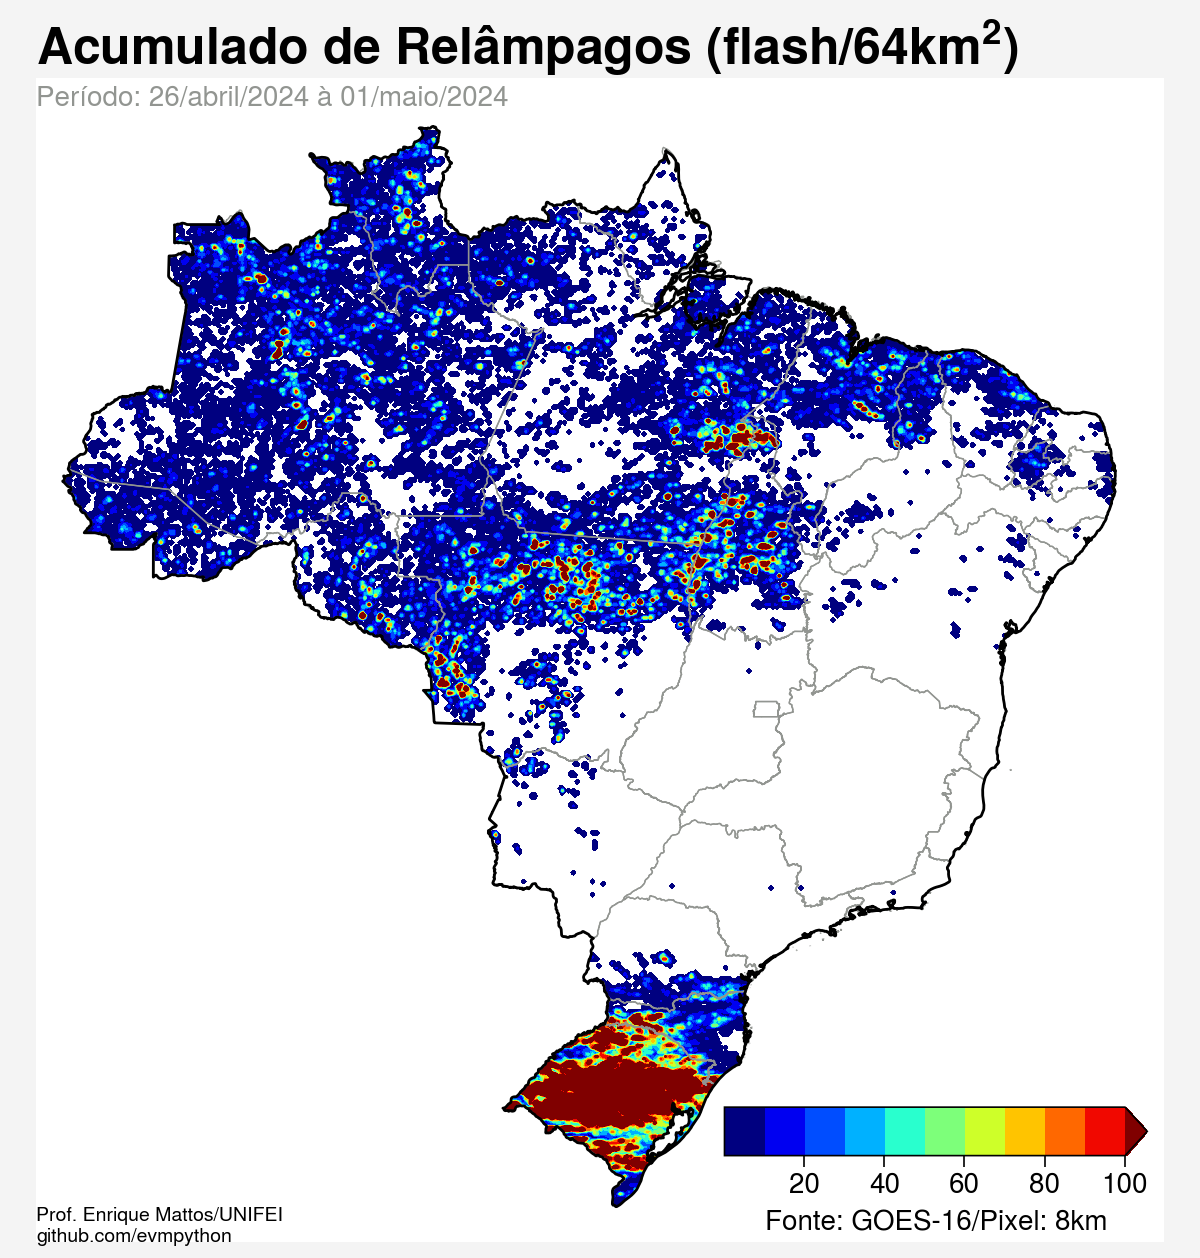

In [11]:
%%time
#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura da figura
fig, ax = pplt.subplots(axwidth=6, tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          small='20px', large='25px',
          linewidth=0, grid=False)

# mapa
map1 = ax.contourf(flash['lon'],
                   flash['lat'],
                   flash[:,:],
                   cmap='jet',
                   vmin=0.1, vmax=100,
                   levels=pplt.arange(0.1, 100, 10),
                   extend='max',
                   colorbar='best',
                   colorbar_kw={'label': 'Fonte: GOES-16/Pixel: 8km',
                                'length': 18,
                                'frameon': False,
                                'ticklabelsize': 10,
                                'labelsize': 10,
                                'width': 2,
                                'ticks': 20})

# título da figura
ax.format(title=f'Acumulado de Relâmpagos (flash/64km$^2$)',
          titleloc='l',
          titleweight='bold',
          titlecolor='black')

# plota subtítulo
ax.text(lonmin, latmax-1.0, f'Período: {diai}/{mesi_name}/{anoi} à {diaf}/{mesf_name}/{anof}', color='grey', fontsize=10)

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax)

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax)

# informação na figura
ax.annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin), fontsize=7, color='black')

# salva figura
fig.save(f'relampagos_goes16_{anoi}{mesi}{diai}_{anof}{mesf}{diaf}.jpg', dpi=300)